# WITHOUT SMOTE

10 Estimators - Train Score: 0.800 | Test Score: 0.694
20 Estimators - Train Score: 0.819 | Test Score: 0.698
30 Estimators - Train Score: 0.843 | Test Score: 0.696
40 Estimators - Train Score: 0.867 | Test Score: 0.690
50 Estimators - Train Score: 0.886 | Test Score: 0.693
60 Estimators - Train Score: 0.902 | Test Score: 0.690
70 Estimators - Train Score: 0.917 | Test Score: 0.688
80 Estimators - Train Score: 0.931 | Test Score: 0.690
90 Estimators - Train Score: 0.942 | Test Score: 0.686
100 Estimators - Train Score: 0.950 | Test Score: 0.677
110 Estimators - Train Score: 0.956 | Test Score: 0.677
120 Estimators - Train Score: 0.961 | Test Score: 0.673
130 Estimators - Train Score: 0.965 | Test Score: 0.675
140 Estimators - Train Score: 0.967 | Test Score: 0.678
150 Estimators - Train Score: 0.969 | Test Score: 0.676
160 Estimators - Train Score: 0.974 | Test Score: 0.670
170 Estimators - Train Score: 0.976 | Test Score: 0.667
180 Estimators - Train Score: 0.979 | Test Score: 0.662
1

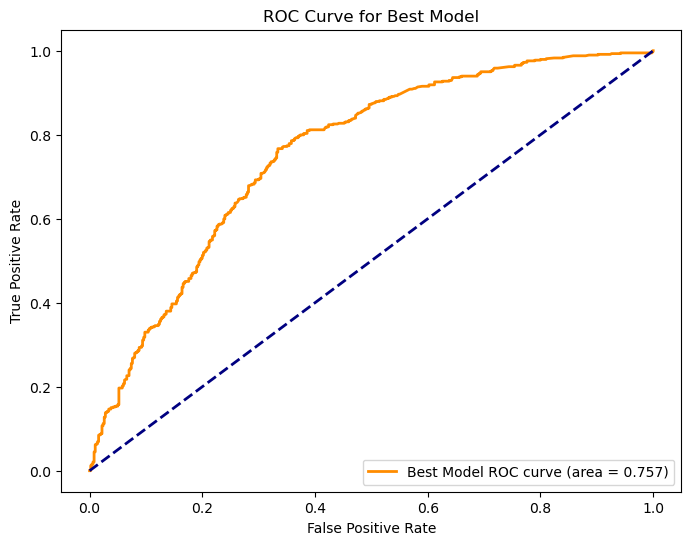

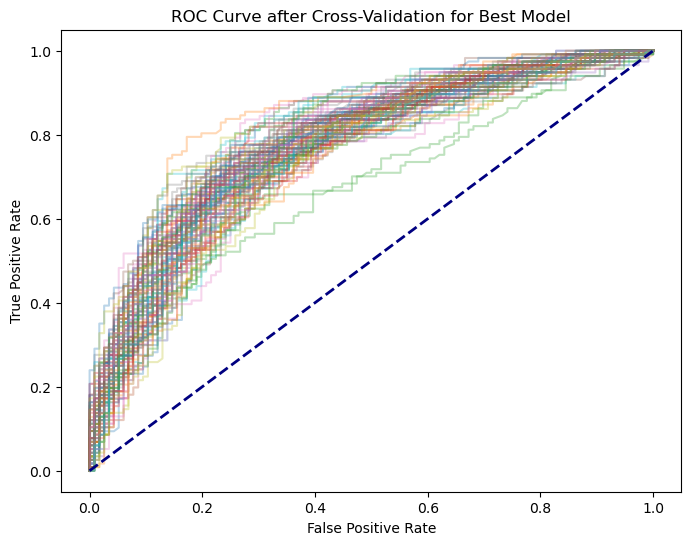

Cross-Validation Results for Best Model:
   Fold  AUC Score
0     1   0.720049
1     2   0.794909
2     3   0.762010
3     4   0.735374
4     5   0.789935
5     6   0.766873
6     7   0.756168
7     8   0.774562
8     9   0.737589
9    10   0.821864

Mean AUC: 0.766
Standard Deviation: 0.029
AUC: 0.757


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# Load your dataset
startup_df = pd.read_csv("modelling_df.csv", delimiter=',', header=0, encoding="ISO-8859-1", skipinitialspace=True)

# Copy the DataFrame for modeling
modelling_df = startup_df.copy()

# One-hot encode categorical variables and prepare features (X) and target variable (y)
X = pd.get_dummies(modelling_df.drop(['status_binary'], axis=1))
y = modelling_df['status_binary']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Test different numbers of estimators for XGBoost
n_estimators_list = list(range(10, 201, 10))

# Track the best model and its score
best_model = None
best_score = 0.0

# Iterate over different numbers of estimators
for n in n_estimators_list:
    # Create an XGBoost Classifier with n_estimators trees
    model = XGBClassifier(n_estimators=n, objective='binary:logistic', random_state=10)

    # Fit the model on the resampled data
    model.fit(X_resampled, y_resampled)

    # Evaluate the model on the test data
    test_score = model.score(X_test, y_test)

    # Print the training and testing scores for the current model
    print('{} Estimators - Train Score: {:.3f} | Test Score: {:.3f}'.format(n, model.score(X_resampled, y_resampled), test_score))

    # Update the best model if the current model performs better
    if test_score > best_score:
        best_score = test_score
        best_model = model

# Use the best model to train on the entire training set
best_model.fit(X_resampled, y_resampled)

# Make predictions on the test set and calculate ROC curve and AUC for the best model
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]
auc_best = roc_auc_score(y_test, y_pred_proba_best)

# Plot ROC curve for the best model
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_proba_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2, label='Best Model ROC curve (area = {:.3f})'.format(auc_best))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Model')
plt.legend(loc='lower right')
plt.show()

# Cross-validation on the resampled data using the best model
cv_scores_best = cross_val_score(best_model, X_resampled, y_resampled, cv=10, scoring='roc_auc')

# Plot ROC curve after cross-validation
plt.figure(figsize=(8, 6))
for train_index, test_index in RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1).split(X_resampled, y_resampled):
    model_cv = XGBClassifier(n_estimators=best_model.n_estimators, objective='binary:logistic', random_state=10)
    model_cv.fit(X_resampled.iloc[train_index], y_resampled.iloc[train_index])
    y_pred_proba_cv = model_cv.predict_proba(X_resampled.iloc[test_index])[:, 1]
    fpr_cv, tpr_cv, _ = roc_curve(y_resampled.iloc[test_index], y_pred_proba_cv)
    plt.plot(fpr_cv, tpr_cv, alpha=0.3)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve after Cross-Validation for Best Model')
plt.show()

# Display the cross-validation results
cv_results_best = pd.DataFrame({
    'Fold': range(1, len(cv_scores_best) + 1),
    'AUC Score': cv_scores_best
})

print("Cross-Validation Results for Best Model:")
print(cv_results_best)
print("\nMean AUC: {:.3f}".format(cv_scores_best.mean()))
print("Standard Deviation: {:.3f}".format(cv_scores_best.std()))

# Calculate AUC
y_proba = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_proba)
print("AUC: {:.3f}".format(auc_score))




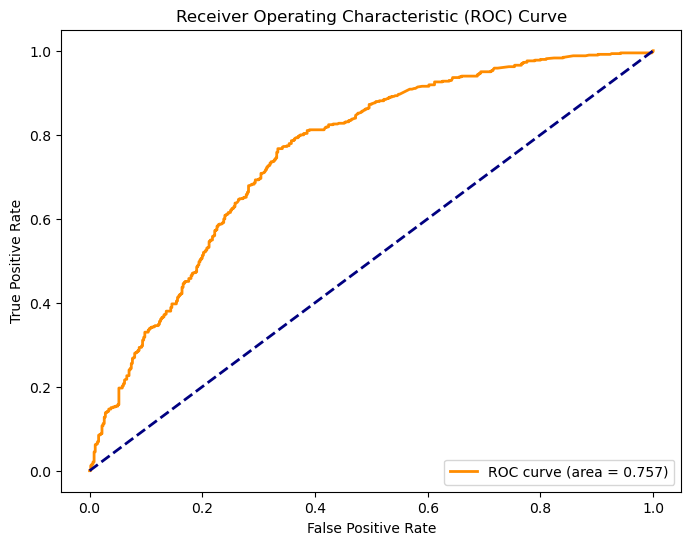

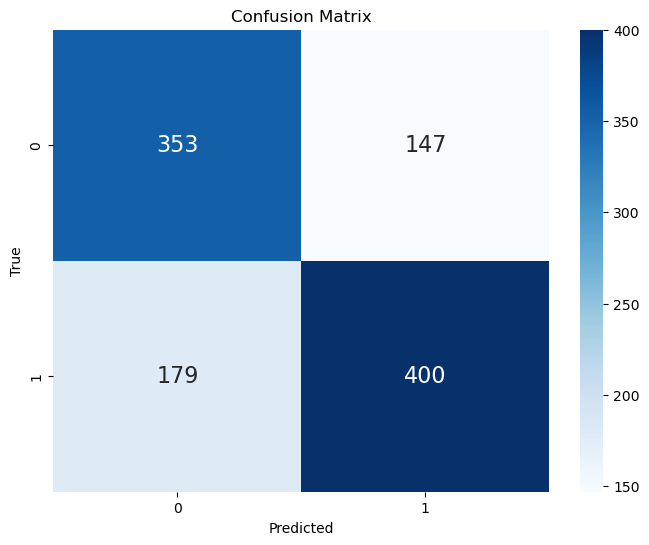


Classification Report:
               precision    recall  f1-score   support

           0      0.664     0.706     0.684       500
           1      0.731     0.691     0.710       579

    accuracy                          0.698      1079
   macro avg      0.697     0.698     0.697      1079
weighted avg      0.700     0.698     0.698      1079



In [7]:
# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.3f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
classification_report_result = classification_report(y_test, y_pred, digits=3)
print("\nClassification Report:\n", classification_report_result)

# WITH SMOTE

Cross-Validation Results:
   Fold  AUC Score
0     1   0.764640
1     2   0.793029
2     3   0.722354
3     4   0.718341
4     5   0.733316
5     6   0.761668
6     7   0.733883
7     8   0.704498
8     9   0.728898
9    10   0.802099

Mean AUC: 0.746
Standard Deviation: 0.031
AUC: 0.738


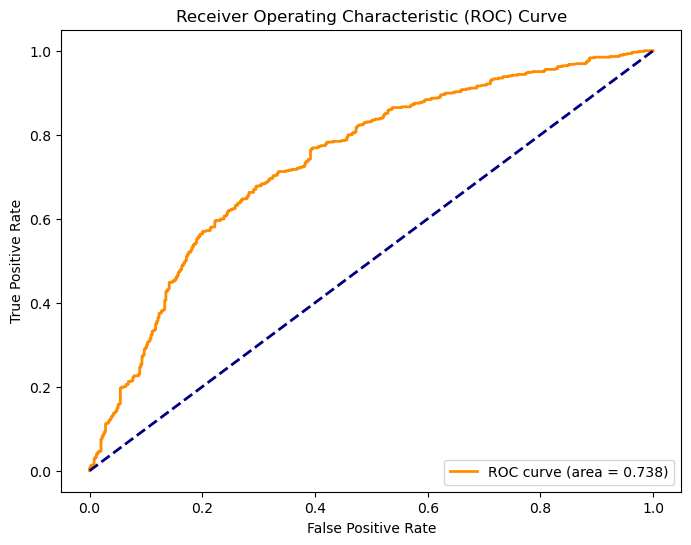

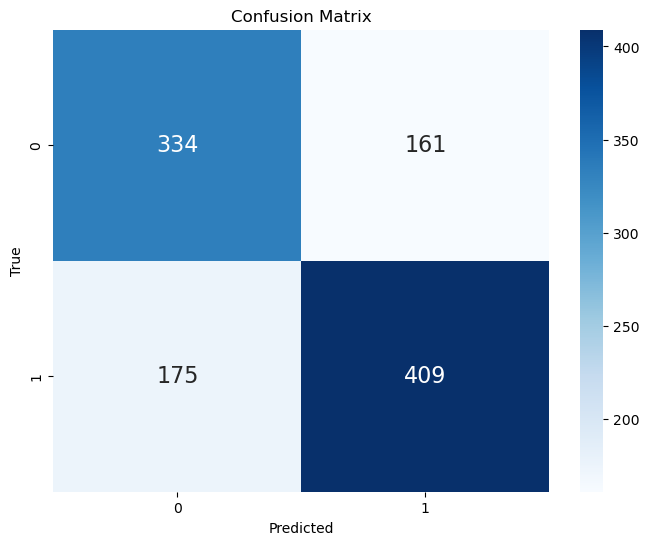


Classification Report:
               precision    recall  f1-score   support

           0      0.656     0.675     0.665       495
           1      0.718     0.700     0.709       584

    accuracy                          0.689      1079
   macro avg      0.687     0.688     0.687      1079
weighted avg      0.689     0.689     0.689      1079



In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
startup_df = pd.read_csv("modelling_df.csv", delimiter=',', header=0, encoding="ISO-8859-1", skipinitialspace=True)

# Data Preparation
X = pd.get_dummies(startup_df.drop(['status_binary'], axis=1))
y = startup_df['status_binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize XGBoost Classifier
model = XGBClassifier()

# Cross-validation on the resampled data
cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=10, scoring='roc_auc')

# Create a DataFrame to display cross-validation results
cv_results = pd.DataFrame({
    'Fold': range(1, len(cv_scores) + 1),
    'AUC Score': cv_scores
})

# Print the table with mean and standard deviation
print("Cross-Validation Results:")
print(cv_results)
print("\nMean AUC: {:.3f}".format(cv_scores.mean()))
print("Standard Deviation: {:.3f}".format(cv_scores.std()))

# Train the model on the resampled data
model.fit(X_train_resampled, y_train_resampled)

# Predictions on the original test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate AUC on the original test set
auc_score = roc_auc_score(y_test, y_proba)
print("AUC: {:.3f}".format(auc_score))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.3f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
classification_report_result = classification_report(y_test, y_pred, digits=3)
print("\nClassification Report:\n", classification_report_result)
